Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import h5py
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Definir variables globales

In [2]:
ancho = 160
alto = 129
canales = 3
pixeles = ancho*alto*canales
cantidadClases = 5
clases = ['Banano', 'Granada', 'Kiwi', 'Mango', 'Pitaya']
batchSize = 64

Definir Función Auxiliar

In [3]:
def view_classify(img, ps):
  ps = ps.data.numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(16,13), ncols=2)
  ax1.imshow(img.numpy().transpose((1, 2, 0)))
  ax1.axis('off')
  ax2.barh(np.arange(cantidadClases), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(cantidadClases))
  ax2.set_yticklabels(clases, size='medium');
  ax2.set_title('Probabilidad de las Clases')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

Importar dataset

In [4]:
#Se transforma a la mitad del tamaño por restricciones de memoria
transform = transforms.Compose([transforms.Resize((ancho, alto)),transforms.ToTensor(),])
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Train')
trainset = ImageFolder(root=dataset_path, transform=transform)
trainloader = DataLoader(trainset, batch_size=batchSize, shuffle=True)

La función de activación será relu para las capas ocultas y softmax para la capa final: https://www.mdpi.com/2079-9292/12/14/3132

Definir la estructura de la red y el forward

In [5]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(pixeles, 20640)
    self.fc2 = nn.Linear(20640, 6880)
    self.fc3 = nn.Linear(6880, 2293)
    self.fc4 = nn.Linear(2293, 764)
    self.fc5 = nn.Linear(764, 254)
    self.fc6 = nn.Linear(254, 84)
    self.fc7 = nn.Linear(84, cantidadClases)
      
  def forward(self, x):
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = F.log_softmax(self.fc7(x), dim=1)
    
    return x

model = Network()

Inicializar pesos y bias

In [6]:
model.fc1.bias.data.fill_(0)
model.fc1.weight.data.normal_(std=0.01)

tensor([[-0.0114, -0.0177,  0.0022,  ...,  0.0047,  0.0018,  0.0016],
        [-0.0118,  0.0166,  0.0161,  ...,  0.0005,  0.0118,  0.0105],
        [ 0.0043,  0.0168, -0.0056,  ...,  0.0099,  0.0014,  0.0011],
        ...,
        [-0.0035,  0.0025,  0.0138,  ..., -0.0012, -0.0047, -0.0099],
        [-0.0109, -0.0159,  0.0045,  ..., -0.0021,  0.0115, -0.0120],
        [ 0.0042,  0.0093, -0.0081,  ..., -0.0002, -0.0181,  0.0038]])

Construir modelo con capas secuenciales

In [7]:
input_size = pixeles
hidden_sizes = [20640, 6880, 2293, 764, 254, 84]
output_size = cantidadClases

model = nn.Sequential(OrderedDict([
  ('capa1',nn.Linear(input_size, hidden_sizes[0])),
  ('actv1',nn.ReLU()),
  ('capa2',nn.Linear(hidden_sizes[0], hidden_sizes[1])),
  ('actv2',nn.ReLU()),
  ('capa3',nn.Linear(hidden_sizes[1], hidden_sizes[2])),
  ('actv3',nn.ReLU()),
  ('capa4',nn.Linear(hidden_sizes[2], hidden_sizes[3])),
  ('actv4',nn.ReLU()),
  ('capa5',nn.Linear(hidden_sizes[3], hidden_sizes[4])),
  ('actv5',nn.ReLU()),
  ('capa6',nn.Linear(hidden_sizes[4], hidden_sizes[5])),
  ('actv6',nn.ReLU()),
  ('capa7',nn.Linear(hidden_sizes[5], output_size)),
  ('actv7',nn.LogSoftmax(dim=1))
]))

Realizar forward

In [8]:
images,labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
ps = model.forward(images[0,:].unsqueeze(0))

Calcular las pérdidas, nuestra predicción de error

In [9]:
criterion = nn.NLLLoss()

images,labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
logps = model(images)
loss = criterion(logps, labels)

print(loss)

tensor(1.6002, grad_fn=<NllLossBackward0>)


Autograd

In [10]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 2.3202e-06,  2.1674e-06,  2.1768e-06,  ...,  2.7571e-06,
          2.4409e-06,  1.6187e-06],
        [ 1.0069e-06,  1.1630e-06,  9.7861e-07,  ..., -9.8762e-07,
         -6.8888e-07,  3.1315e-07],
        [ 2.5647e-06,  2.5155e-06,  2.3803e-06,  ...,  3.1328e-06,
          2.8191e-06,  2.4378e-06],
        ...,
        [ 2.3491e-06,  2.2841e-06,  2.2170e-06,  ...,  2.6536e-06,
          2.4617e-06,  1.8816e-06],
        [ 7.1854e-08,  7.1854e-08,  7.4100e-08,  ...,  5.5462e-07,
          5.3217e-07,  5.4789e-07],
        [-1.8800e-07, -1.7612e-07, -1.2230e-07,  ..., -5.0231e-06,
         -4.7891e-06, -4.1857e-06]])


Iniciar entrenamiento

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(batchSize, pixeles)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-1.4043e-03,  9.3400e-04,  2.6200e-03,  ..., -5.4890e-04,
          2.0764e-03,  7.1751e-04],
        [ 4.3185e-04, -3.9300e-03, -4.5951e-04,  ...,  9.9839e-04,
          2.2488e-03, -2.9523e-03],
        [-6.9983e-04, -2.5571e-03,  3.2318e-03,  ..., -8.8911e-04,
         -7.6631e-04, -4.9618e-04],
        ...,
        [-2.2924e-03,  9.1590e-04, -1.9229e-03,  ...,  1.0449e-03,
         -4.0010e-04,  8.1536e-04],
        [-9.7675e-05, -2.7940e-03, -9.9581e-04,  ..., -4.4153e-05,
         -6.5642e-04, -2.8938e-03],
        [ 3.0042e-03, -2.8272e-03, -6.0405e-04,  ...,  1.6908e-03,
          3.4028e-03,  2.4797e-03]], requires_grad=True)
Gradient - tensor([[ 1.0292e-06,  9.0245e-07,  8.4237e-07,  ..., -4.3345e-09,
          3.0788e-07,  2.5307e-07],
        [ 3.7150e-07,  3.0072e-07,  2.6769e-07,  ..., -2.2287e-06,
         -1.9484e-06, -1.7640e-06],
        [-9.1787e-07, -9.2320e-07, -1.1048e-06,  ..., -5.8712e-06,
         -6.3014e-06, -

In [12]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-1.4043e-03,  9.3399e-04,  2.6200e-03,  ..., -5.4890e-04,
          2.0764e-03,  7.1750e-04],
        [ 4.3185e-04, -3.9300e-03, -4.5951e-04,  ...,  9.9841e-04,
          2.2488e-03, -2.9523e-03],
        [-6.9982e-04, -2.5571e-03,  3.2318e-03,  ..., -8.8905e-04,
         -7.6625e-04, -4.9611e-04],
        ...,
        [-2.2924e-03,  9.1588e-04, -1.9229e-03,  ...,  1.0449e-03,
         -4.0009e-04,  8.1538e-04],
        [-9.7672e-05, -2.7940e-03, -9.9581e-04,  ..., -4.4147e-05,
         -6.5642e-04, -2.8938e-03],
        [ 3.0042e-03, -2.8272e-03, -6.0405e-04,  ...,  1.6909e-03,
          3.4028e-03,  2.4796e-03]], requires_grad=True)


Entrenamiento parte 2

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.6101312738353923
Training loss: 1.6088707416744557
Training loss: 1.6078471602019617
Training loss: 1.6066913392584203
Training loss: 1.6056899196010526


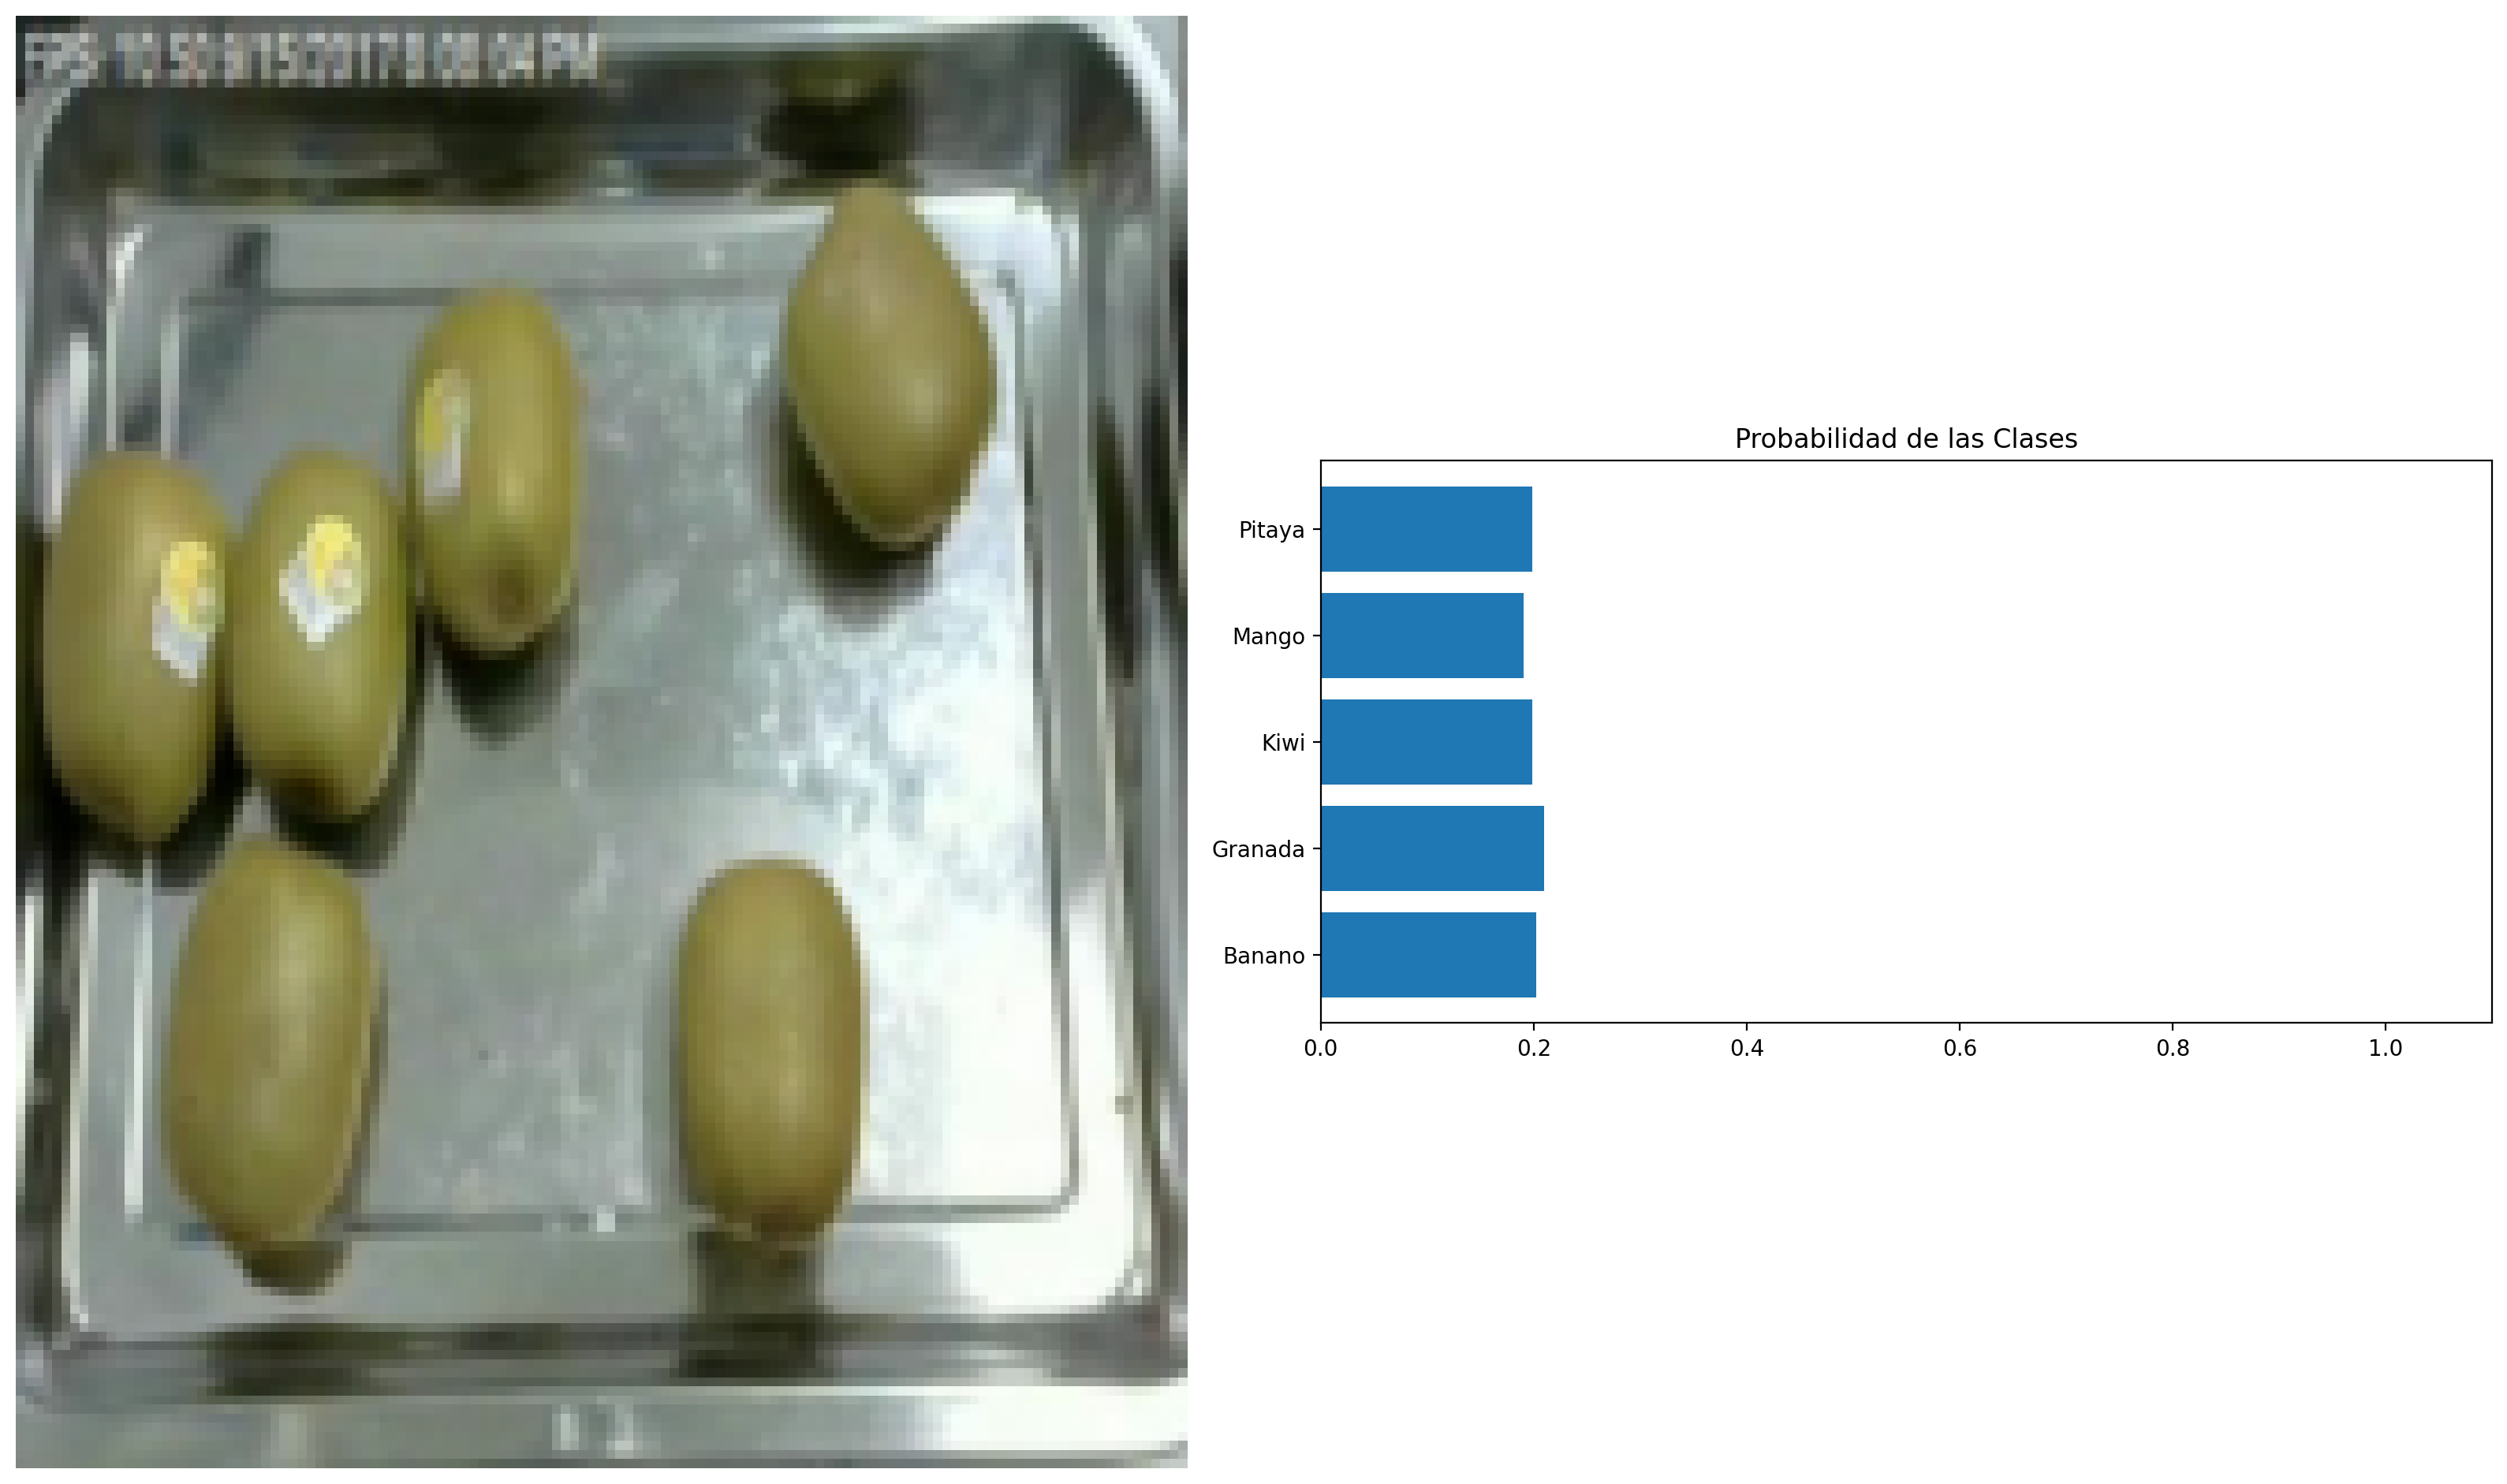

In [14]:
images, labels = next(iter(trainloader))

img = images[0].view(1, pixeles)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(canales, ancho, alto), ps)

**Guía 4**

Importar dataset de prueba

In [15]:
#Se transforma a la mitad del tamaño por restricciones de memoria
transform = transforms.Compose([transforms.Resize((ancho, 129)),transforms.ToTensor(),])
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Test')
testset = ImageFolder(root=dataset_path, transform=transform)
testloader = DataLoader(testset, batch_size=batchSize, shuffle=True)

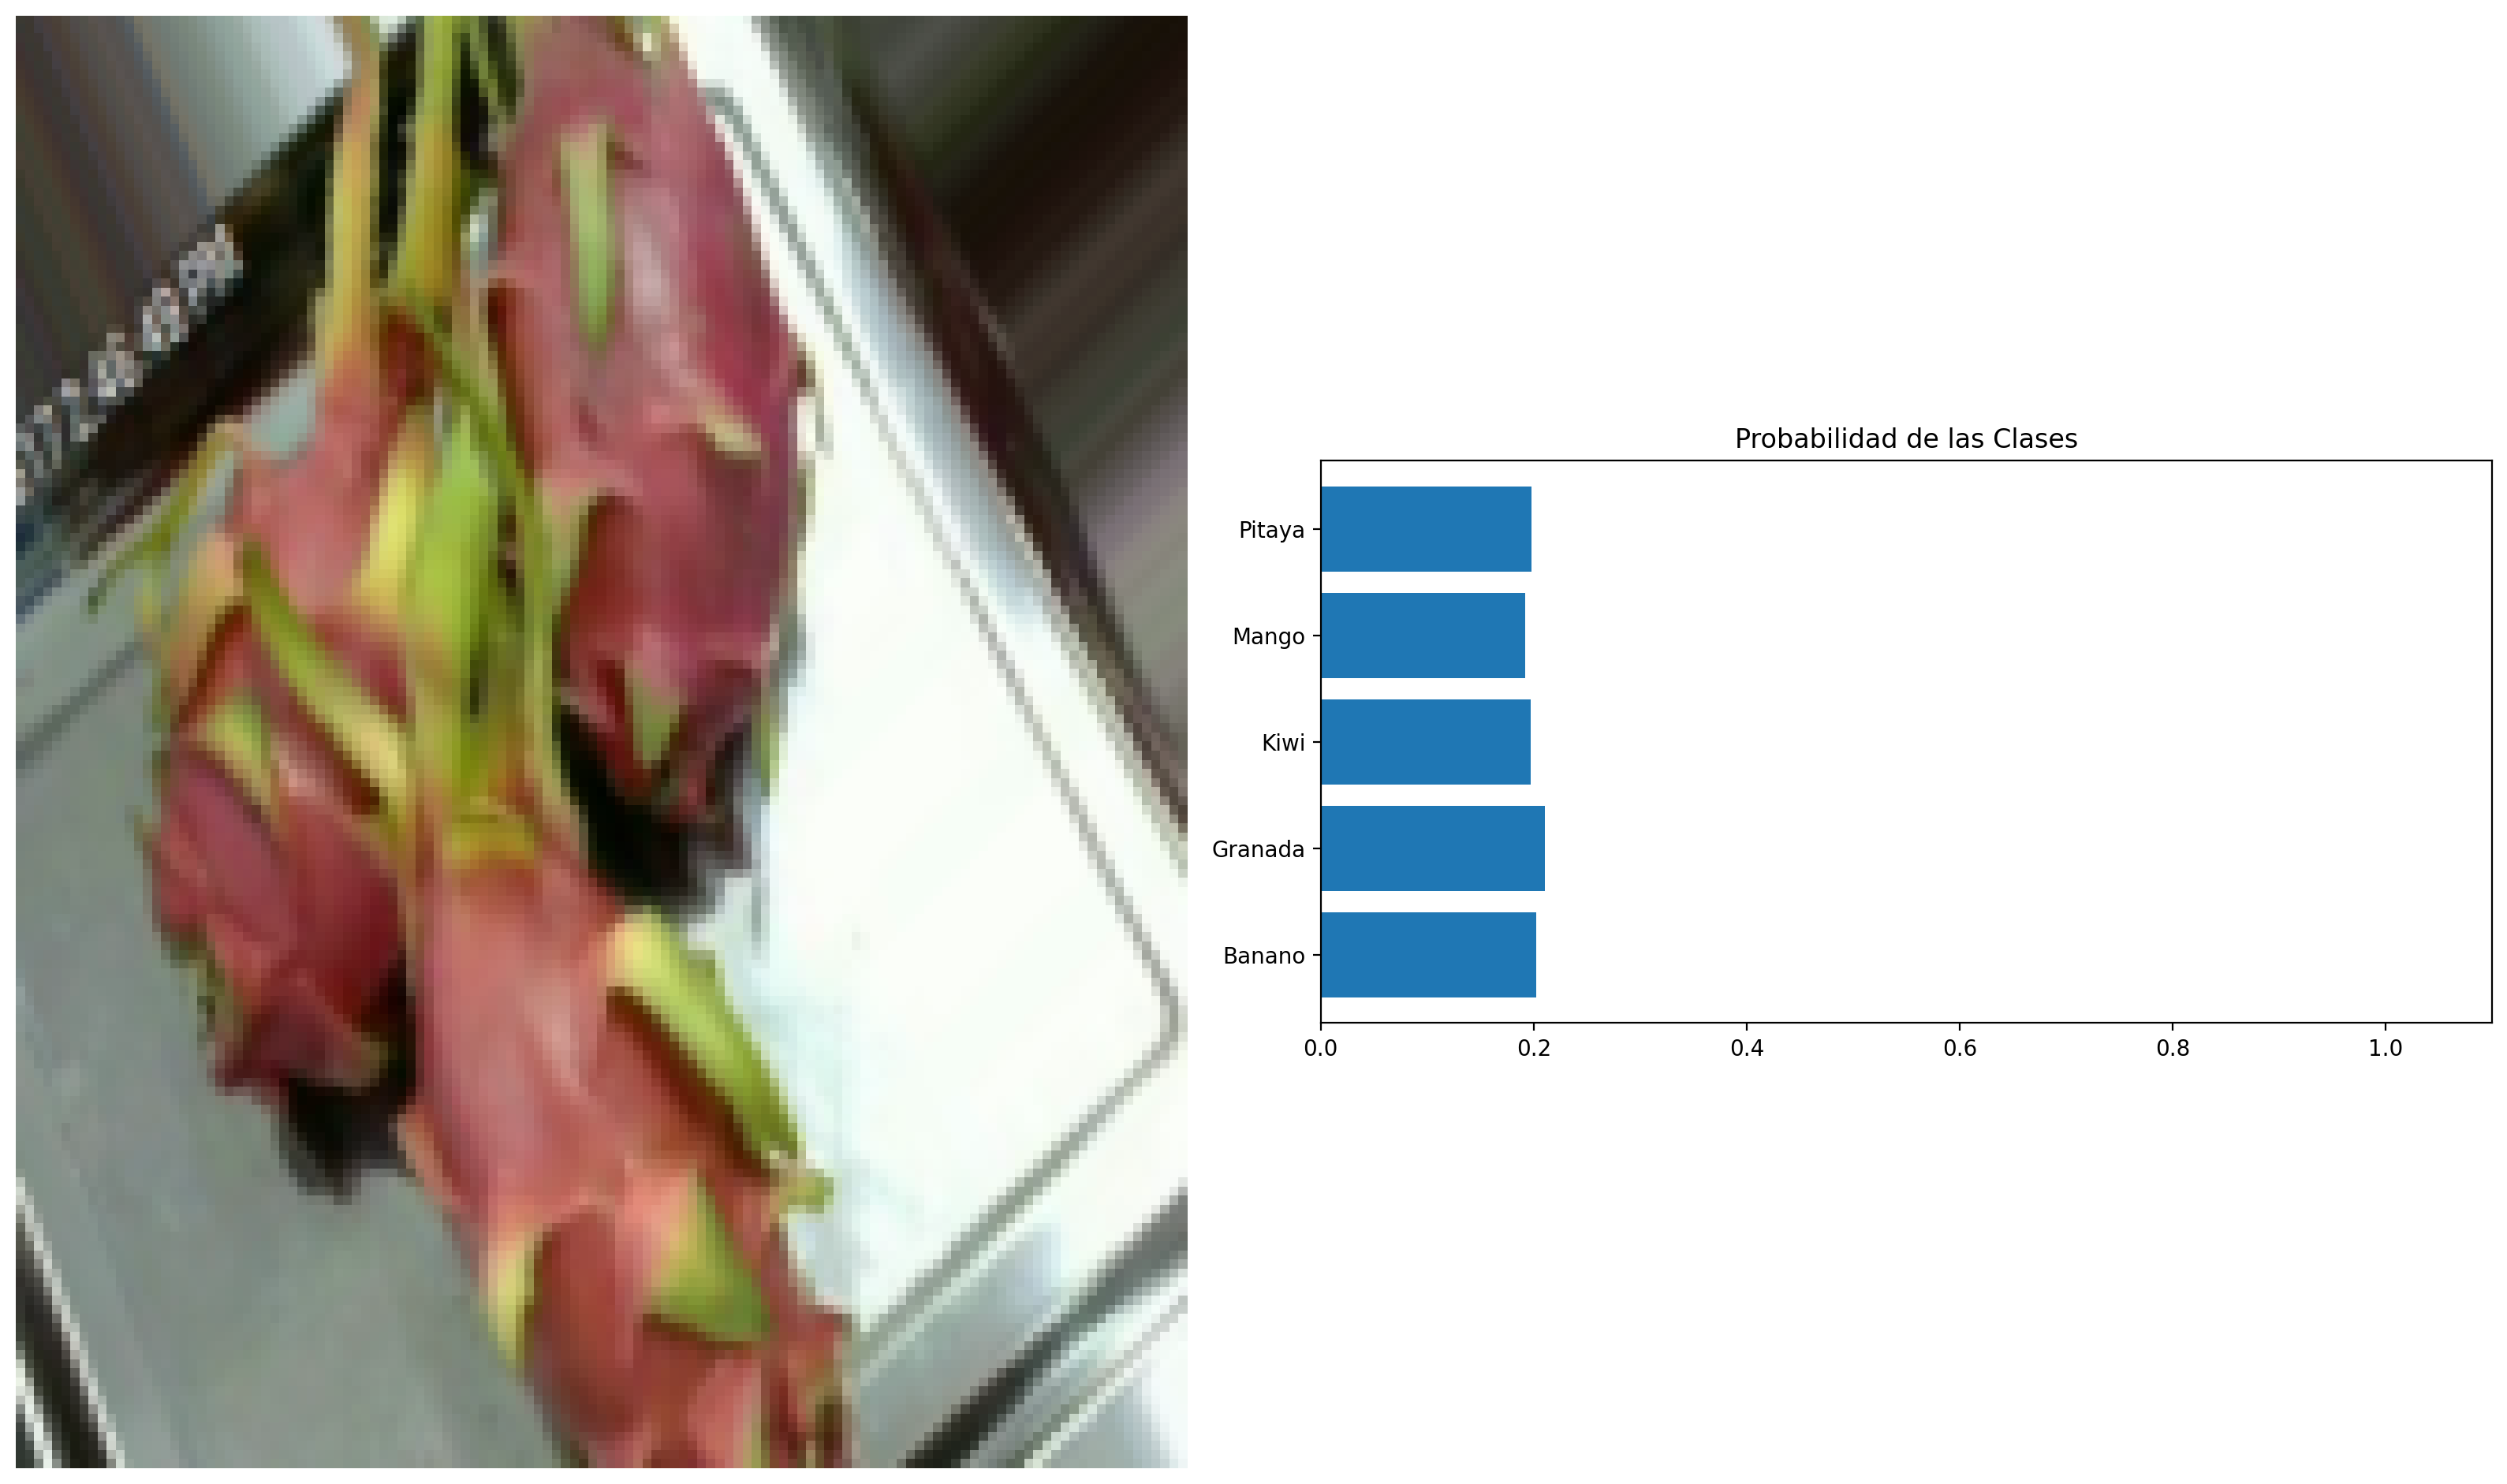

In [17]:
dataiter = iter(testloader)
images, labels = next(iter(testloader))
img = images[1].view(1, pixeles)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
view_classify(img.view(canales, ancho, alto), ps)